In [124]:
import matplotlib.pyplot as plt
%matplotlib inline

In [125]:
import healpy as hp 
import numpy as np
import os.path 
from os.path import exists as file_exists
import pymaster as nmt
import matplotlib.cm as cm
import matplotlib as mpl
import pyccl as ccl
from scipy import stats
import copy

NoneType

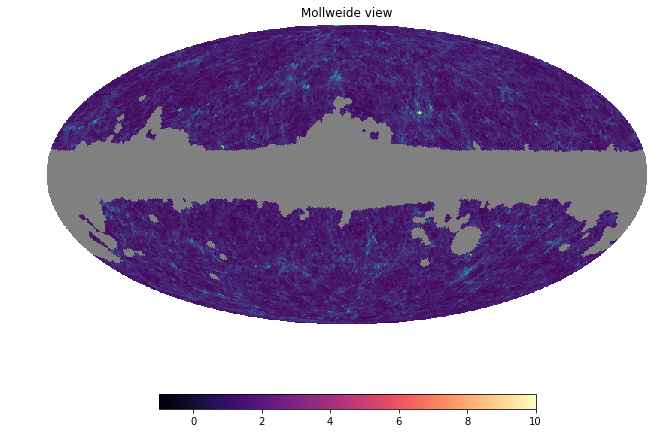

In [126]:
# plt.clf()
galmap_read = hp.ud_grade(hp.read_map('map_WIxSCx2M__0.fits'),nside_out = 64)#1024)
mask = hp.ud_grade(hp.read_map('mask_galaxies.fits'), nside_out=64)
#data = np.random.randn(hp.nside2npix(128))
fig, ax = plt.subplots()
msk = mask == 0
galmap_read[msk] = hp.UNSEEN
# galmap_read[~msk] = np.log10(galmap_read[~msk])
c = hp.mollview(galmap_read, cbar=None, hold=True, min=-1, max=10)
plt.hist(galmap_read)
ax = fig.gca()
im = ax.get_images()[0]
cmap = cm.magma
b = im.norm.inverse(np.linspace(0, 1, im.cmap.N + 1))
v = np.linspace(im.norm.vmin, im.norm.vmax, im.cmap.N)
mappable = cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=im.norm.vmin, vmax=im.norm.vmax), cmap=cmap)
mappable.set_array(v)
f = plt.gcf()
f.colorbar(mappable,
           ax=ax,
          orientation="horizontal",
          shrink=0.5,
          aspect=25,
          pad=0.05,
          fraction=0.1)
fig.set_size_inches(13.5, 8.5)
plt.savefig('galmap.jpg', format = 'jpg', dpi =100 )
type(c)

In [127]:
choose_file = []
for i in range(0,6):
    for j in range(0,12):
        for filename in os.listdir('/mnt/zfsusers/anyabua/FermiX'):
            if filename == "W_galagam_" + str(i)+"x"+str(j)+".npz":
                choose_file.append(str(filename))
data_files = np.reshape(choose_file,(6,12))

ells = np.load(data_files[0][0])['ells']
all_jackerrors = {f'jkerr{gal}x{gam}': np.squeeze(np.load(data_files[gal][gam])['jack_error']) for gal in range(0,6) for gam in range(0,12)} 
all_pcl = {f'galaxy x gamma:{gal}x{gam}': np.squeeze(np.load(data_files[gal][gam])['PCL_fskydivided']) for gal in range(0,6) for gam in range(0,12)} 
all_bpw = {f'bpw{gal}x{gam}': np.load(data_files[gal][gam])['bpw'] for gal in range(0,6) for gam in range(0,12)} 
all_JKCL = {f'JKCL{gal}x{gam}': np.load(data_files[gal][gam])['ells'] for gal in range(0,6) for gam in range(0,12)}


/usr/lib/python3/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


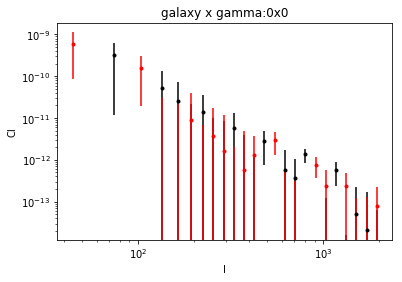

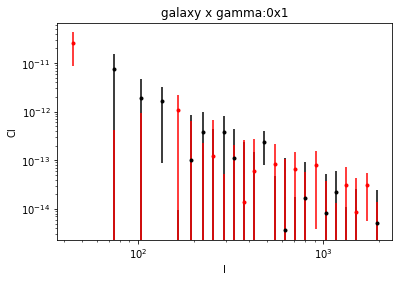

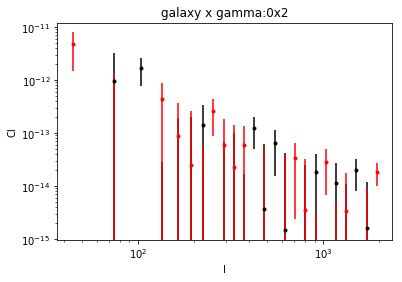

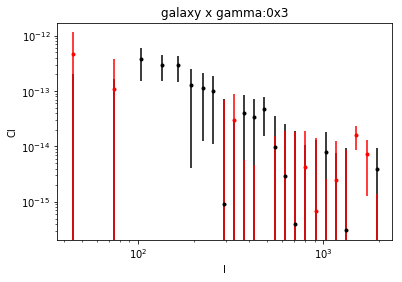

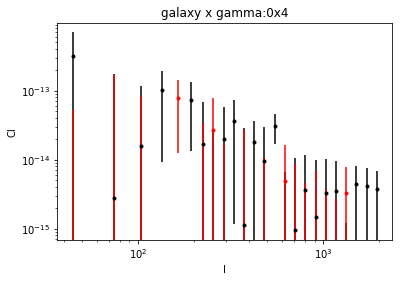

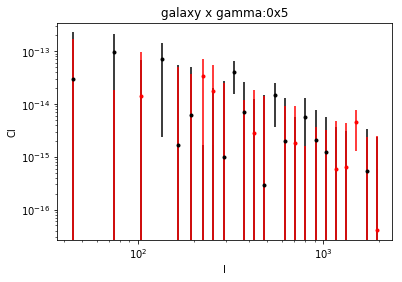

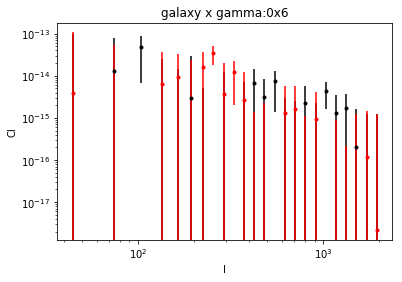

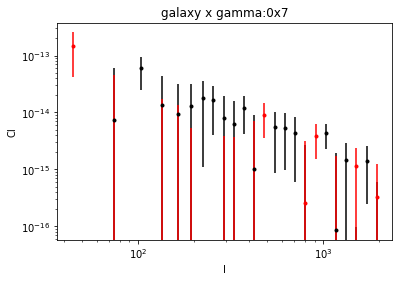

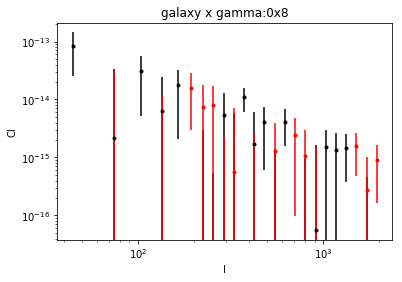

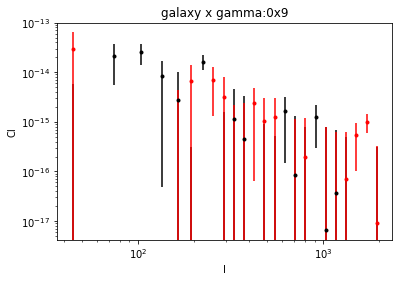

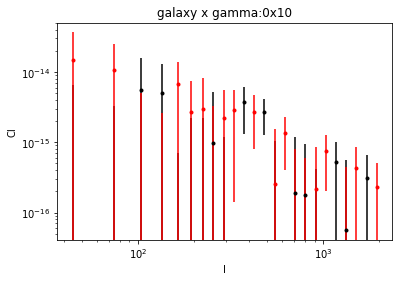

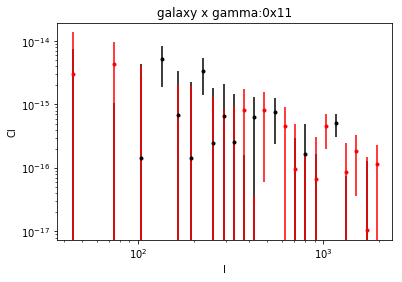

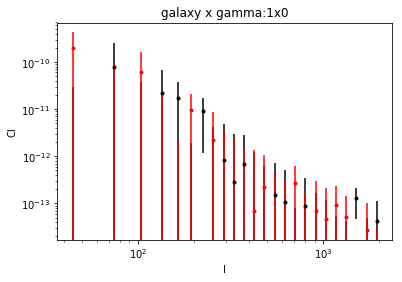

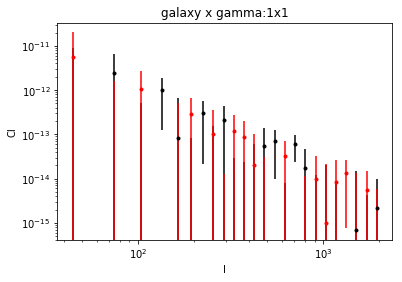

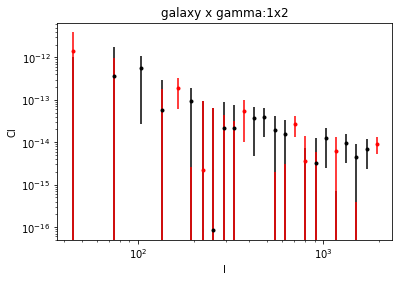

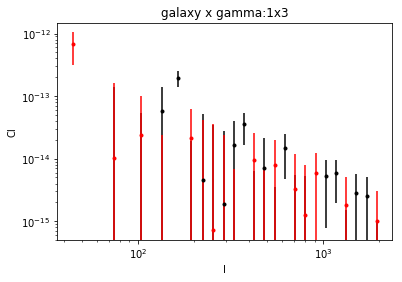

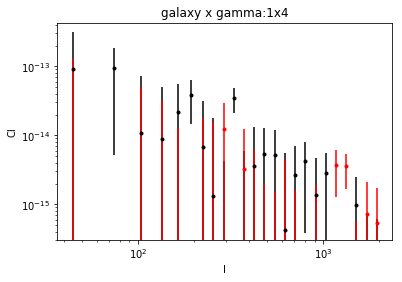

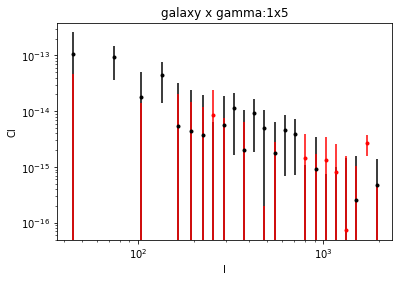

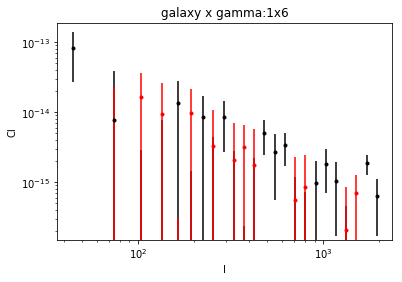

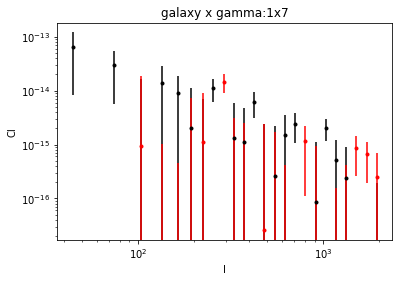

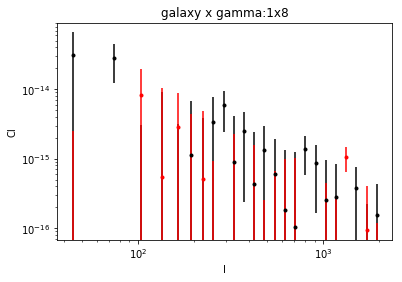

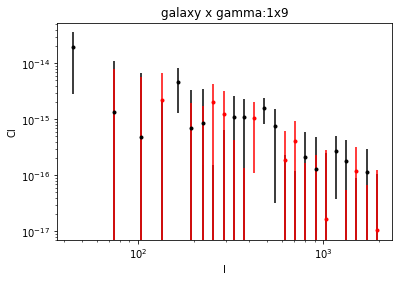

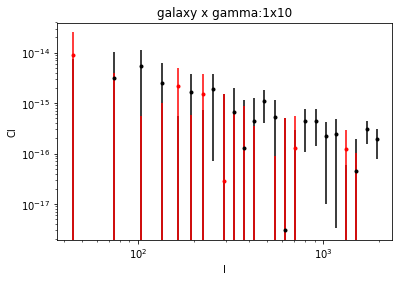

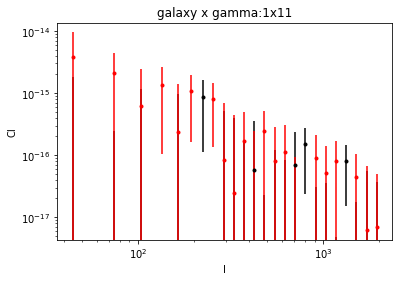

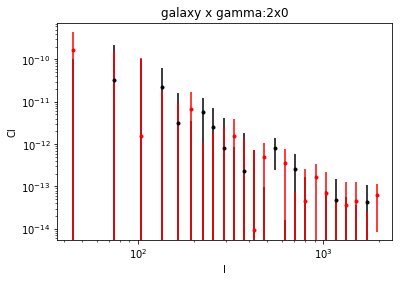

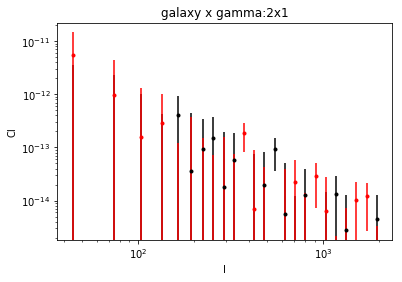

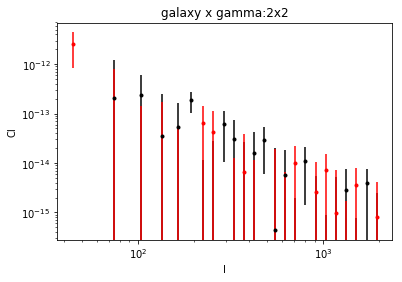

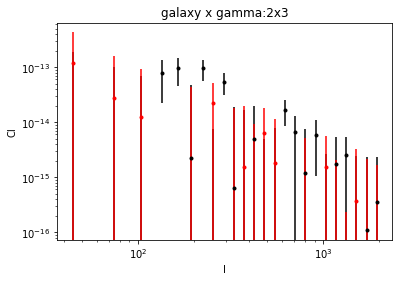

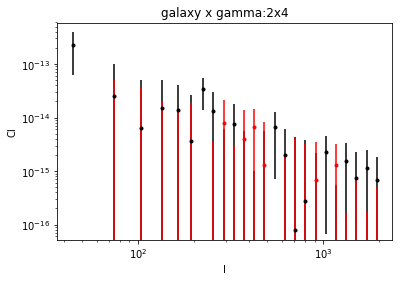

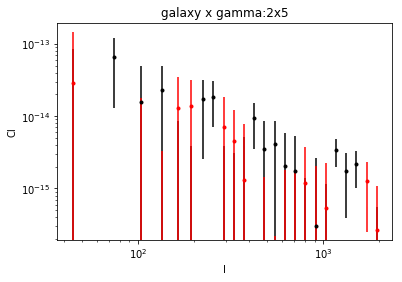

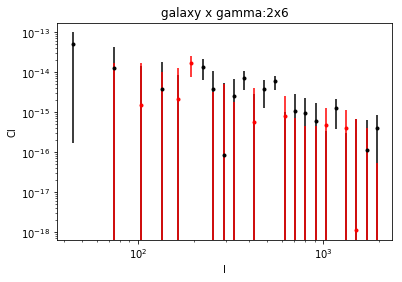

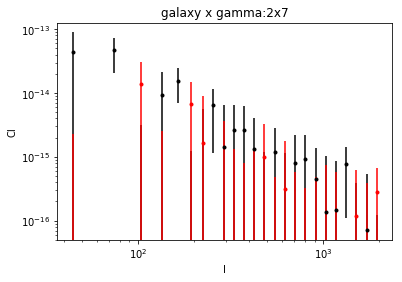

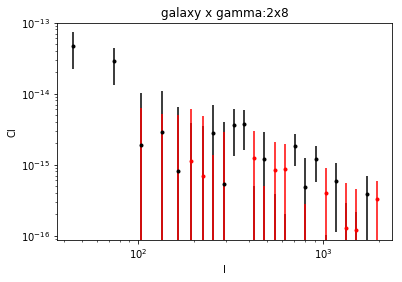

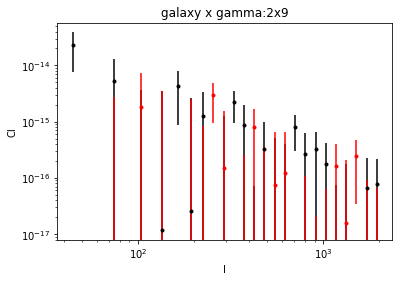

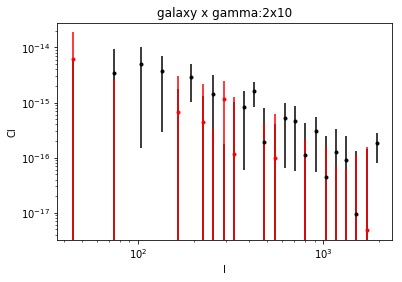

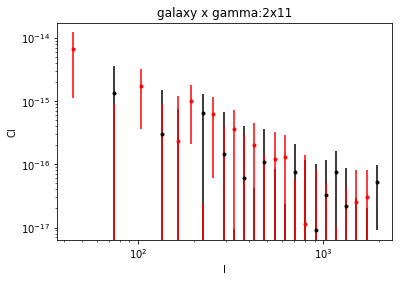

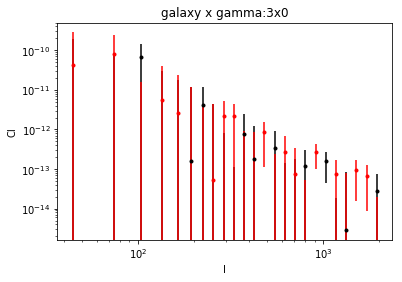

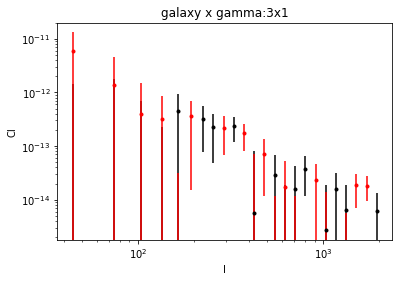

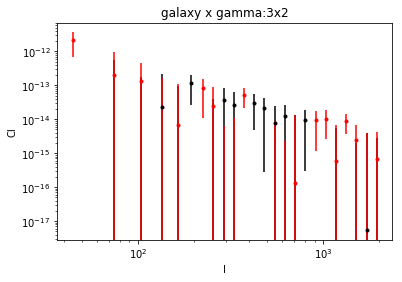

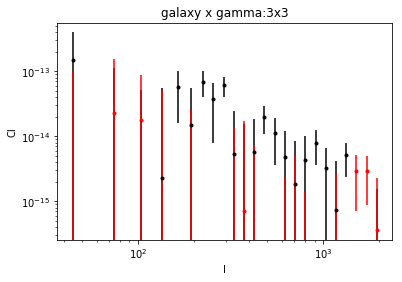

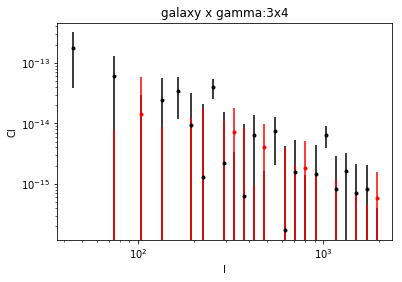

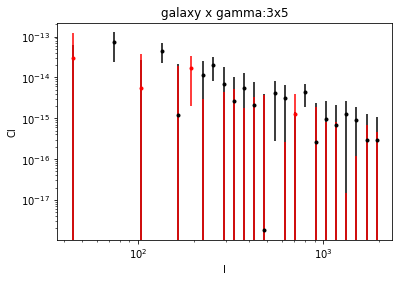

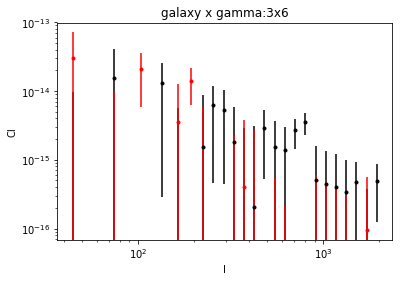

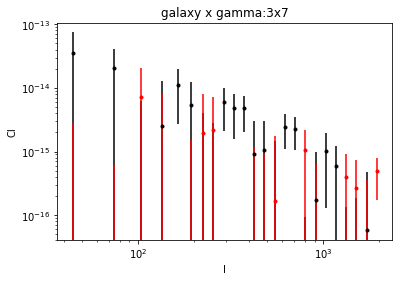

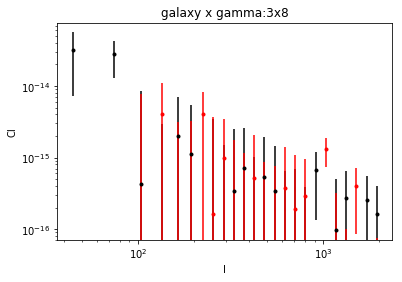

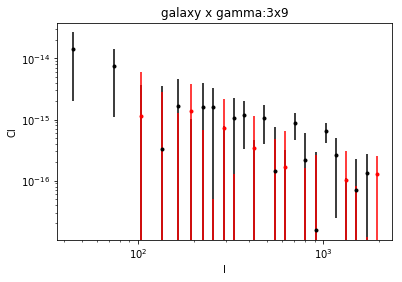

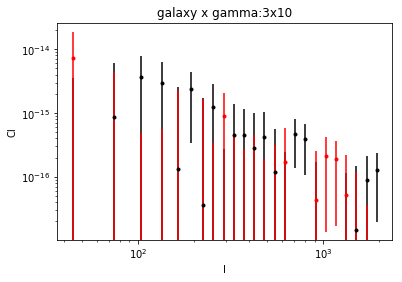

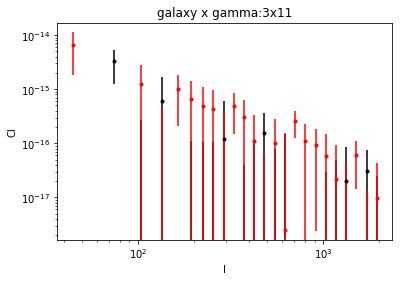

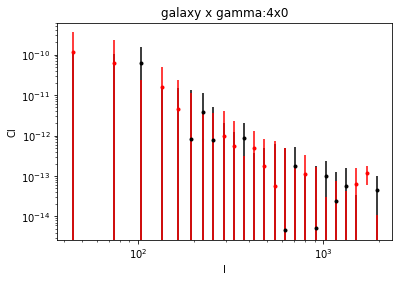

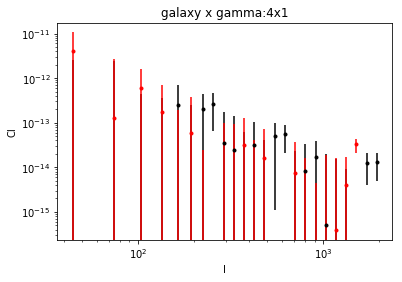

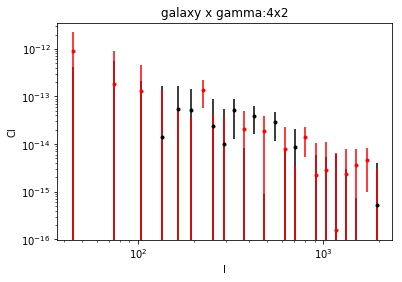

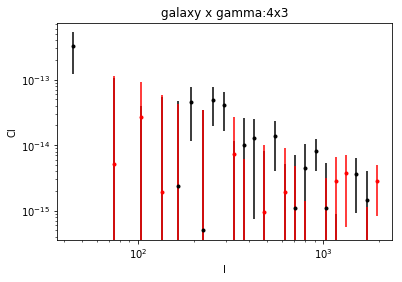

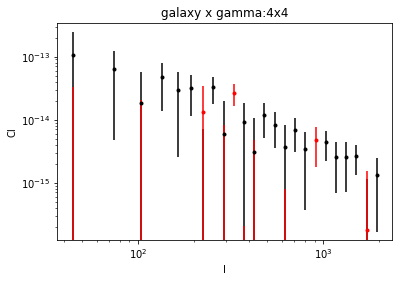

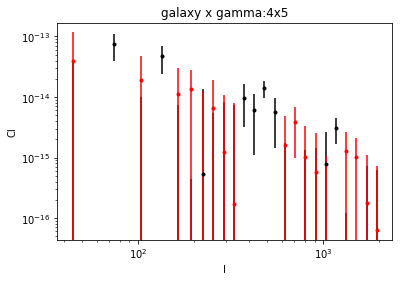

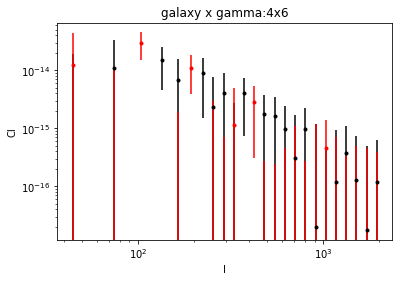

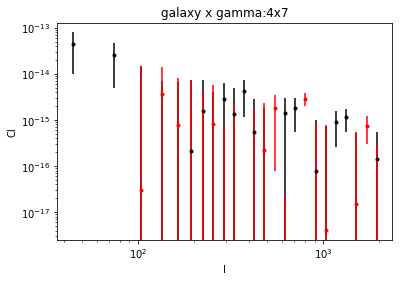

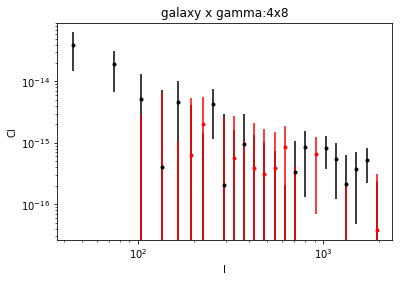

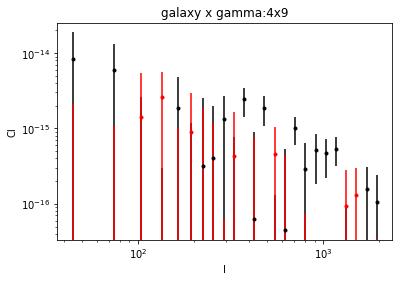

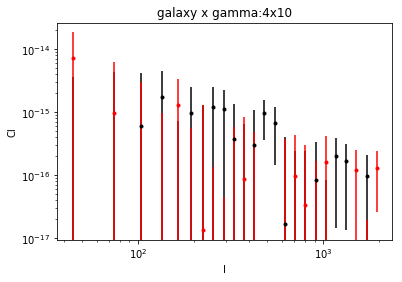

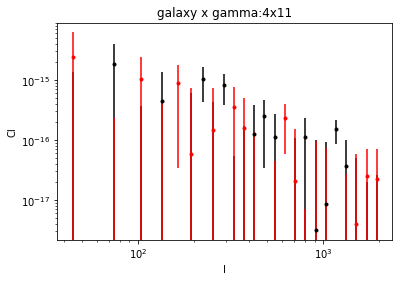

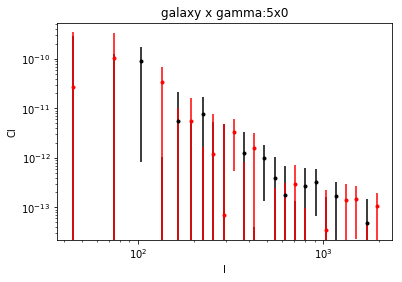

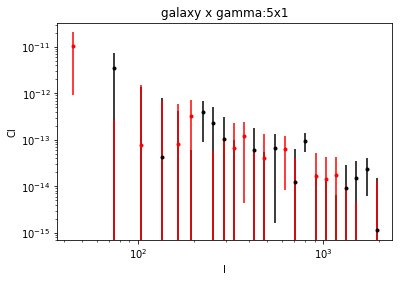

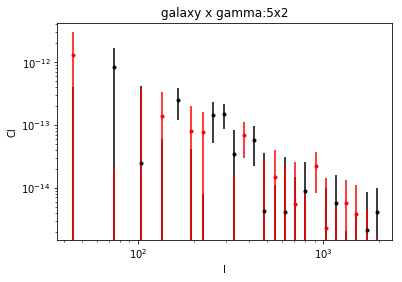

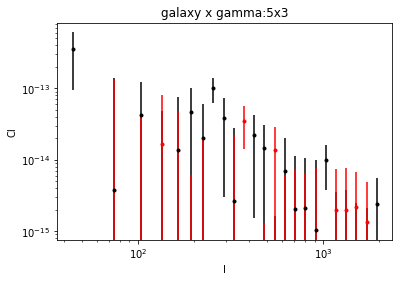

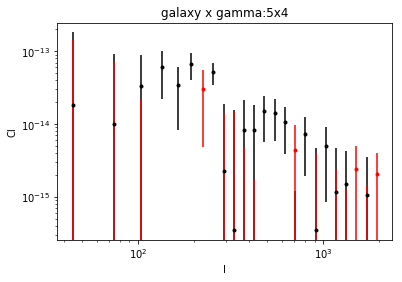

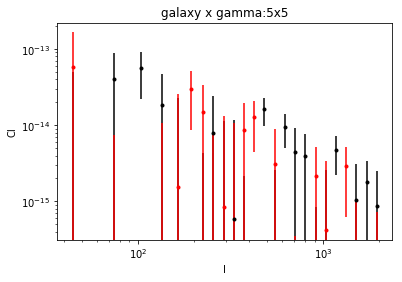

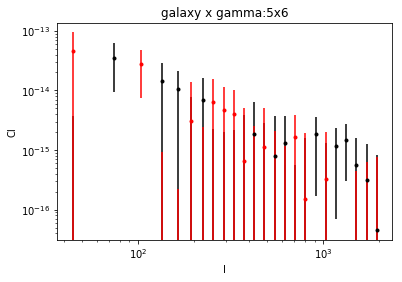

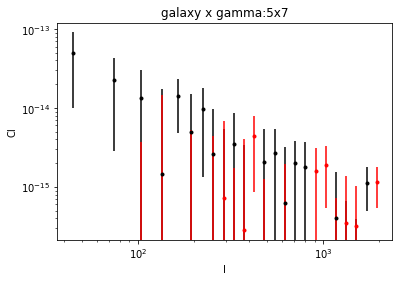

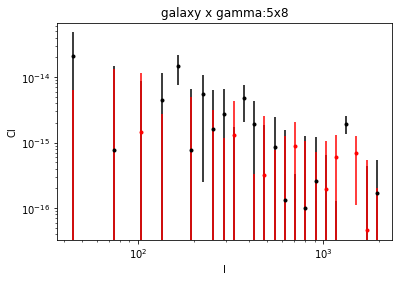

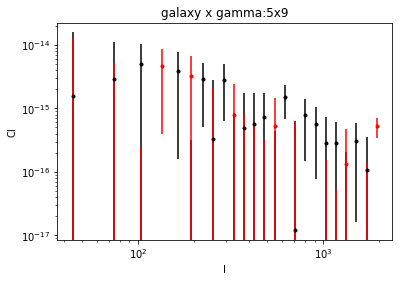

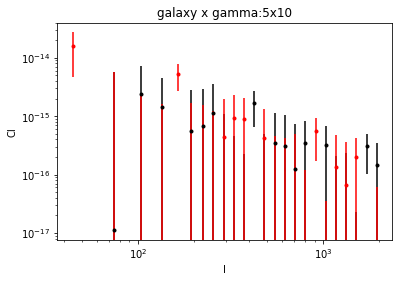

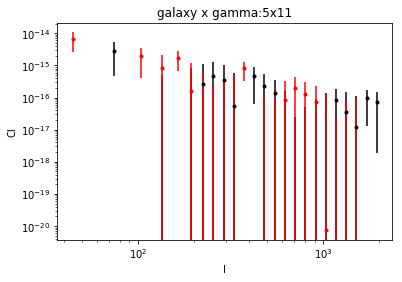

In [128]:
### PLOTS ###  

def plot_PCL_and_jackerrors(PCL_data,jackerrors,nside):
    fig, ax = plt.subplots()
    ax.errorbar(ells, PCL_data,jackerrors, fmt = 'k.')
    ax.errorbar(ells, -PCL_data,jackerrors, fmt = 'r.')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('l')
    ax.set_ylabel('Cl')


plot_names = list(all_pcl.keys())

for pcl, jackerr, name in zip(all_pcl.values(),all_jackerrors.values(),plot_names):
    plot_PCL_and_jackerrors(pcl,jackerr,1024)
    plt.title(f'{name}')
    fig.set_size_inches(13.5, 8.5)
    plt.savefig(f'{name}.jpg', format = 'jpg', dpi =100 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


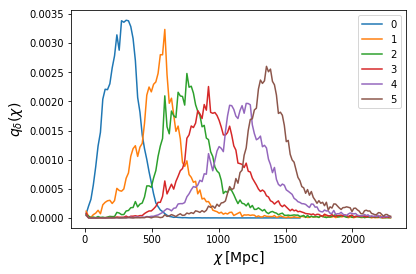

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


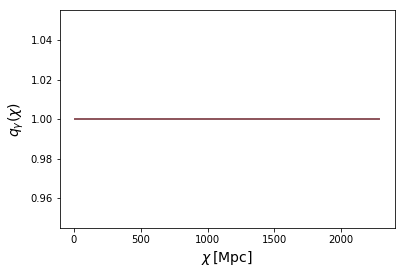

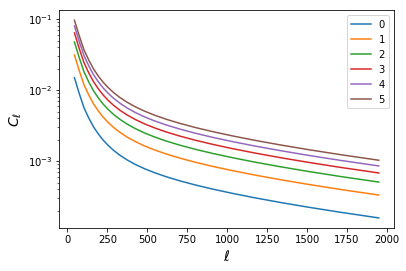

In [129]:
# ____________________________________________________PRELIMINARIES__________________________________________________________#
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)

k_arr = np.geomspace(1E-4,100,256) # no of k arr was originally 256

z = {}
dndz = {}
ay = []

for gal in range(0,6):
    z[f'{gal}'], dndz[f'{gal}'] = np.loadtxt(f"dndz_bin{gal}.txt", unpack=True)
    a = 1./(1+z[f'{gal}']) 
    ay.append(a)

    

a_arr = [i[::-1] for i in ay] #makes scale factor monotonically increasing
chi = [ccl.comoving_radial_distance(cosmo,a_s) for a_s in a_arr]

# ___________________________________galaxy_tracer____________________________________________________________________________#

t_g = []
g_kernel = []

GRB_tracer = ccl.Tracer()

for gal in range(0,6):
    t_gal = ccl.NumberCountsTracer(cosmo, has_rsd = False, dndz=(z[f'{gal}'],dndz[f'{gal}']), bias=(z[f'{gal}'], np.ones_like(z[f'{gal}'])))
    gal_kernel = ccl.get_density_kernel(cosmo, (z[f'{gal}'],dndz[f'{gal}'])) 
    g_kernel.append(gal_kernel)

chis_and_kern= np.array(g_kernel[:])
chis = chis_and_kern[:][:,0]
kernels = chis_and_kern[:][:,1]

glabels = np.arange(len(kernels))
for p,q,b in zip(chis,kernels,glabels):
    plt.plot(p,q, label = f'{b}')
    plt.xlabel('$\\chi\\,[{\\rm Mpc}]$', fontsize=14)
    plt.ylabel('$q_\\delta(\\chi)$', fontsize=14)
    plt.legend()
fig.set_size_inches(13.5, 8.5)
plt.savefig('radialkernel galaxies.jpg', format = 'jpg', dpi =300 , bbox_inches='tight' )
plt.show()

#___________________________________________________gamma_tracer_______________________________________________________________#
def try_kernel(alpha,chi,z):
            kernel = (1+z)**alpha #missing proportionality factors
            gamma_kernel_and_chi = [chi,kernel]
            return gamma_kernel_and_chi
        

gamma_kernel_and_chi = []
for gal in range(0,6):
    gam_kernel = try_kernel(0,chis[gal],z[f'{gal}']) #### INPUT ALPHA HERE #### 
    gamma_kernel_and_chi.append(gam_kernel)
    
gam_chis = np.array(gamma_kernel_and_chi[:])    
chi = gam_chis[:][:,0]
gammakernels = gam_chis[:][:,1]


for x,y in zip(chi, gammakernels):
    plt.plot(x,y)
    plt.xlabel('$\\chi\\,[{\\rm Mpc}]$',fontsize=14)
    plt.ylabel('$q_\\gamma(\\chi)$',fontsize=14)
#fig.set_size_inches(10.5, 5.5)
plt.savefig('radialkernel gamma0.jpg', format = 'jpg', dpi =200, bbox_inches = 'tight' )
plt.show()

#______________________________________________theoretical_Cls________________________________________________________________#
cl_theoretical = []
cl_arr = []
plt.figure()

for gal in range(0,6):
    GRB_tracer.add_tracer(cosmo, kernel = gamma_kernel_and_chi[gal])
    cl_theory = ccl.angular_cl(cosmo, GRB_tracer , t_gal, ells, p_of_k_a = None)
    cl_theoretical.append(cl_theory)
    theory = np.tile(cl_theoretical[gal], (12,1))
    cl_arr.append(theory)

    #uses Limber approx
    #p_of_k_a default is a matter matter cross spectrum (a better approximation than the HOD model)

    plt.plot(ells, cl_theoretical[gal], label = f'{gal}')
    plt.legend()
    plt.yscale('log')
    #plt.xscale('log')
    plt.ylabel('$C_\\ell$', fontsize = 14)
    plt.xlabel('$\\ell$', fontsize = 14)




(72,)
(72,)


Text(36.625,0.5,'Galaxy redshift bin')

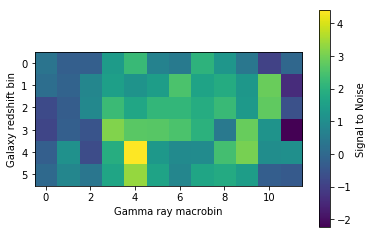

In [130]:
ess2_all = []
aay_arg_all = []


#the variable aay/ess is the signal to noise ratio 

for gal in range(0,6):
    for gam in range(0,12):
        ess2_calc = 1/(np.sum((cl_arr[gal][gam]/all_jackerrors[f'jkerr{gal}x{gam}'])**2))
        ess2_all.append(ess2_calc)
        aay_argcalc = np.sum(all_pcl[f'galaxy x gamma:{gal}x{gam}']*cl_arr[gal][gam]/(all_jackerrors[f'jkerr{gal}x{gam}']**2))
        aay_arg_all.append(aay_argcalc)

print(np.shape(ess2_all))
ess = np.sqrt(ess2_all)
aay= np.array(aay_arg_all)*np.array(ess2_all)

signal_to_noise = aay/ess
print(np.shape(signal_to_noise))


signal_to_noise = np.reshape(signal_to_noise,(6,12))
plt.imshow(signal_to_noise, cmap = 'viridis', interpolation = 'nearest')
bar = plt.colorbar()
bar.set_label('Signal to Noise')
fig.set_size_inches(13.5, 8.5)
plt.savefig('firstsignaltonoise.jpg', format = 'jpg', dpi =100 )
plt.xlabel('Gamma ray macrobin')
plt.ylabel('Galaxy redshift bin')

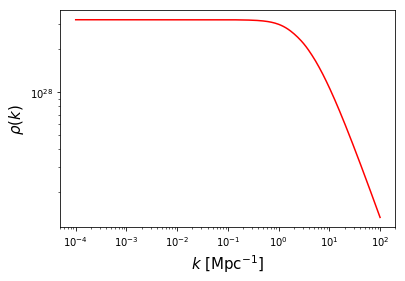

In [131]:
from scipy.special import sici

#Creating a Halo profile that describes Dark matter annihilation in k-space. The DarkMatterAnnihilationProfile is the Fourier
#transform of the NFW profile squared. This is then used to compute the Pk2D(Matter x Dark Matter Annihilation) 
#and compared with the Pk2D (Matter x Matter) obtained from just the standard NFW profile (also in k-space). 
#These are the two competing models for that data points.

#the rho^1 is for decay 
#the rho^2 is for annihilation

# We will use a mass definition with Delta = 200 times the matter density
hmd_200c = ccl.halos.MassDef200c() 

# The Duffy 2008 concentration-mass relation
cM = ccl.halos.ConcentrationDuffy08(hmd_200c)

# The Tinker 2008 mass function
nM = ccl.halos.MassFuncTinker08(cosmo, mass_def=hmd_200c)

# The Tinker 2010 halo bias
bM = ccl.halos.HaloBiasTinker10(cosmo, mass_def=hmd_200c)

# The NFW profile to characterize the matter density around halos
pM = ccl.halos.profiles.HaloProfileNFW(cM)

class DarkMatterAnnihilationProfile(ccl.halos.HaloProfile):
    def __init__(self,c_M_relation):
        self.cM = c_M_relation
        super().__init__()
        
    def _get_cM(self, cosmo, M, a, mdef=None):
        return self.cM.get_concentration(cosmo, M, a, mdef_other = mdef)
    
    def _fourier(self, cosmo, k , M , a , mass_def):
        M_use = np.atleast_1d(M)
        k_use = np.atleast_1d(k)
    
        
        R_M = mass_def.get_radius(cosmo, M_use, a) / a #comoving virial radius
        c_M =self._get_cM(cosmo,M_use,a,mass_def)
    
        R_s = R_M / c_M
        rho0 = M_use / (4 * np.pi * R_s**3)

        q = k_use[None, :] * R_s[:, None]
        
        
        Si_q, Ci_q = sici(q)
        P1 = M_use / (np.log(1 + c_M) - c_M/ (1 + c_M))
        c_M = c_M[:, None]
        Si_oneplusc, Ci_oneplusc = sici((1 + c_M) * q)
        Si_qc, Ci_qc = sici(q*c_M)
        
        A = (rho0 * P1)[:, None] / q
        
        Si1 = Si_oneplusc - Si_q
        Ci1 = Ci_oneplusc - Ci_q
        
        q_half = (1-(q**2)/2)
        q_sixth = (q-(q**3)/6)
        
        Si_term = Si1*(q_half*np.cos(q)+ q_sixth*np.sin(q))
        Ci_term = Ci1*(q_half*np.sin(q)-q_sixth*np.cos(q))
        
        sin_term = np.sin(q*c_M)*((6*(1 + c_M)**2 + 5 + 3*c_M - (q**2)*(1+c_M)**2)/(6*(1 + c_M)**3))
        cos_term = q*np.cos(q*c_M)*(4 + 3*c_M)/(6*(1 + c_M)**2)
      
        prof = A*(Si_qc - Si_term + Ci_term - 2*q/3 + sin_term + cos_term)
     
        
        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
    
        return prof
        
                           

pDM = DarkMatterAnnihilationProfile(cM)
u_k = pDM._fourier(cosmo,k_arr,1E15,0.5,hmd_200c)
NFWprof = ccl.halos.HaloProfileNFW(cM, truncated=False)
u_k_nfw = NFWprof.fourier(cosmo,k_arr,1E15,0.5,hmd_200c)
plt.figure()
plt.plot(k_arr,u_k,'r-')
#plt.plot(k_arr,u_k_nfw,'k-')

plt.ylabel(r'$\rho(k)$', fontsize=15)
plt.xlabel(r'$k\,\,[{\rm Mpc^{-1}}]$', fontsize=15)

plt.xscale('log')
plt.yscale('log')
fig.set_size_inches(10.5, 5.5)
plt.savefig('DarkMatterAnnihilation profile.jpg', format = 'jpg', dpi =300 )


hmc = ccl.halos.HMCalculator(cosmo, nM, bM, hmd_200c)
pk_DMxMf = ccl.halos.halomod_Pk2D(cosmo, hmc, pDM, prof2=pM,
                                  normprof1=True, normprof2=True,
                                  lk_arr=np.log(k_arr), a_arr=a_arr[0])
pk_MxMf = ccl.halos.halomod_Pk2D(cosmo, hmc, pM, prof2=pM,
                                 normprof1=True, normprof2=True,
                                 lk_arr=np.log(k_arr), a_arr=a_arr[0])
cl_MxM = ccl.angular_cl(cosmo, t_gal, GRB_tracer, ells, p_of_k_a= pk_MxMf)
cl_DxM = ccl.angular_cl(cosmo, t_gal, GRB_tracer, ells, p_of_k_a=pk_DMxMf)

[]

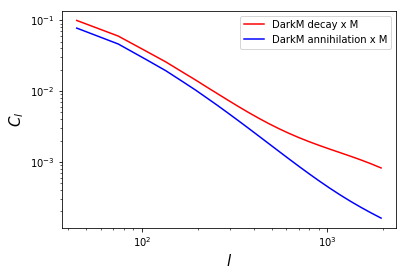

In [132]:
plt.figure()
plt.plot(ells, cl_MxM, 'r-', label = 'DarkM decay x M')
plt.plot(ells, cl_DxM, 'b-', label = 'DarkM annihilation x M')
plt.xlabel('$l$', fontsize =15)
plt.ylabel('$C_{l}$', fontsize = 15)
plt.legend()
plt.loglog()

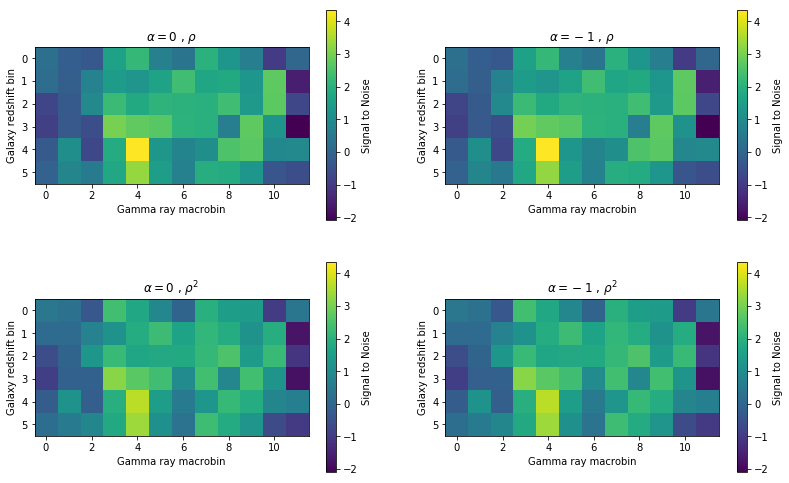

In [133]:
#___________________________________________ALPHA = 0 ________________________________________________________________________#


#RHO TO THE POWER OF 1 (NFW)
gamma_kernel_and_chi0 = []
for gal in range(0,6):
    gam_kernel0 = try_kernel(0,chis[gal],z[f'{gal}']) #### INPUT ALPHA HERE #### 
    gamma_kernel_and_chi0.append(gam_kernel0)


ess2_all10 = []
aay_arg_all10 = []
cl_theoretical10 = []
cl_rho0 = []

GRB_tracer10 = ccl.Tracer()
for gal in range(0,6):
    GRB_tracer10.add_tracer(cosmo, kernel = gamma_kernel_and_chi0[gal])
    cl_theory10 = ccl.angular_cl(cosmo, t_gal, GRB_tracer10, ells, p_of_k_a= pk_MxMf)
    cl_theoretical10.append(cl_theory10)
    theory10 = np.tile(cl_theoretical10[gal], (12,1))
    cl_rho0.append(theory10)



for gal in range(0,6):
    for gam in range(0,12):
        ess2_calc10 = 1/(np.sum((cl_rho0[gal][gam]/all_jackerrors[f'jkerr{gal}x{gam}'])**2))
        ess2_all10.append(ess2_calc10)
        aay_argcalc10 = np.sum(all_pcl[f'galaxy x gamma:{gal}x{gam}']*cl_rho0[gal][gam]/(all_jackerrors[f'jkerr{gal}x{gam}']**2))
        aay_arg_all10.append(aay_argcalc10)


ess10 = np.sqrt(ess2_all10)
aay10= np.array(aay_arg_all10)*np.array(ess2_all10)

signal_to_noise10 = aay10/ess10


signal_to_noise10 = np.reshape(signal_to_noise10,(6,12))




#RHO SQUARED

ess2_all20 = []
aay_arg_all20 = []
cl_theoretical20=[]
cl_rhorho0=[]


GRB_tracer20 = ccl.Tracer()
for gal in range(0,6):
    GRB_tracer20.add_tracer(cosmo, kernel = gamma_kernel_and_chi0[gal])
    cl_theory20 = ccl.angular_cl(cosmo, t_gal, GRB_tracer20, ells, p_of_k_a=pk_DMxMf)
    cl_theoretical20.append(cl_theory20)
    theory20 = np.tile(cl_theoretical20[gal], (12,1))
    cl_rhorho0.append(theory20)

    
    

for gal in range(0,6):
    for gam in range(0,12):
        ess2_calc20 = 1/(np.sum((cl_rhorho0[gal][gam]/all_jackerrors[f'jkerr{gal}x{gam}'])**2))
        ess2_all20.append(ess2_calc20)
        aay_argcalc20 = np.sum(all_pcl[f'galaxy x gamma:{gal}x{gam}']*cl_rhorho0[gal][gam]/(all_jackerrors[f'jkerr{gal}x{gam}']**2))
        aay_arg_all20.append(aay_argcalc20)


ess20 = np.sqrt(ess2_all20)
aay20= np.array(aay_arg_all20)*np.array(ess2_all20)

signal_to_noise20 = aay20/ess20
signal_to_noise20 = np.reshape(signal_to_noise20,(6,12))


#______________________________________ALPHA  = -1 ____________________________________________________________________________#

#RHO TO THE POWER OF 1 (NFW)
gamma_kernel_and_chi1= []
for gal in range(0,6):
    gam_kernel1 = try_kernel(-1,chis[gal],z[f'{gal}']) #### INPUT ALPHA HERE #### 
    gamma_kernel_and_chi1.append(gam_kernel1)
    
    
ess2_all11 = []
aay_arg_all11 = []
cl_theoretical11=[]
cl_rho1=[]   
    
GRB_tracer11 = ccl.Tracer()
for gal in range(0,6):
    GRB_tracer11.add_tracer(cosmo, kernel = gamma_kernel_and_chi1[gal])
    cl_theory11 = ccl.angular_cl(cosmo, t_gal, GRB_tracer11, ells, p_of_k_a= pk_MxMf)
    cl_theoretical11.append(cl_theory11)
    theory11 = np.tile(cl_theoretical11[gal], (12,1))
    cl_rho1.append(theory11)



for gal in range(0,6):
    for gam in range(0,12):
        ess2_calc11 = 1/(np.sum((cl_rho1[gal][gam]/all_jackerrors[f'jkerr{gal}x{gam}'])**2))
        ess2_all11.append(ess2_calc11)
        aay_argcalc11 = np.sum(all_pcl[f'galaxy x gamma:{gal}x{gam}']*cl_rho1[gal][gam]/(all_jackerrors[f'jkerr{gal}x{gam}']**2))
        aay_arg_all11.append(aay_argcalc11)


ess11 = np.sqrt(ess2_all11)
aay11= np.array(aay_arg_all11)*np.array(ess2_all11)

signal_to_noise11 = aay11/ess11




signal_to_noise11 = np.reshape(signal_to_noise11,(6,12))




ess2_all21 = []
aay_arg_all21 = []
cl_theoretical21=[]
cl_rhorho1=[]


GRB_tracer21 = ccl.Tracer()
for gal in range(0,6):
    GRB_tracer21.add_tracer(cosmo, kernel = gamma_kernel_and_chi1[gal])
    cl_theory21 = ccl.angular_cl(cosmo, t_gal, GRB_tracer21, ells, p_of_k_a=pk_DMxMf)
    cl_theoretical21.append(cl_theory21)
    theory21 = np.tile(cl_theoretical21[gal], (12,1))
    cl_rhorho1.append(theory21)
    
    

for gal in range(0,6):
    for gam in range(0,12):
        ess2_calc21 = 1/(np.sum((cl_rhorho1[gal][gam]/all_jackerrors[f'jkerr{gal}x{gam}'])**2))
        ess2_all21.append(ess2_calc21)
        aay_argcalc21 = np.sum(all_pcl[f'galaxy x gamma:{gal}x{gam}']*cl_rhorho1[gal][gam]/(all_jackerrors[f'jkerr{gal}x{gam}']**2))
        aay_arg_all21.append(aay_argcalc21)


ess21 = np.sqrt(ess2_all21)
aay21= np.array(aay_arg_all21)*np.array(ess2_all21)

signal_to_noise21 = aay21/ess21
signal_to_noise21 = np.reshape(signal_to_noise21,(6,12))




#________________________________________________________PLOTTING_____________________________________________________________#

rows = 2
columns = 2


fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 1)
  

plt.imshow(signal_to_noise10)
plt.title("$\\alpha = 0$ , $\\rho$")
bar = plt.colorbar()
bar.set_label('Signal to Noise')
plt.xlabel('Gamma ray macrobin')
plt.ylabel('Galaxy redshift bin')

fig.add_subplot(rows, columns, 2)
  

plt.imshow(signal_to_noise11)
plt.title("$\\alpha = -1$ , $\\rho$ ")
bar = plt.colorbar()
bar.set_label('Signal to Noise')
plt.xlabel('Gamma ray macrobin')
plt.ylabel('Galaxy redshift bin')

fig.add_subplot(rows, columns, 3)

plt.imshow(signal_to_noise20,vmin= -2.1, vmax = 4.34)
plt.title("$\\alpha = 0$ , $\\rho^{2}$ ")
bar = plt.colorbar()
bar.set_label('Signal to Noise')
plt.xlabel('Gamma ray macrobin')
plt.ylabel('Galaxy redshift bin')

fig.add_subplot(rows, columns, 4)

plt.imshow(signal_to_noise21,vmin= -2.1, vmax = 4.34)
plt.title("$\\alpha = -1$ , $\\rho^{2}$")
bar = plt.colorbar()
bar.set_label('Signal to Noise')
plt.xlabel('Gamma ray macrobin')
plt.ylabel('Galaxy redshift bin')

fig.set_size_inches(13.5, 8.5)
plt.savefig('Imshowplots.jpg', format = 'jpg', dpi =100 )


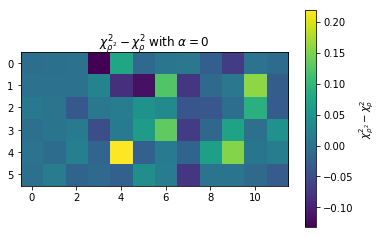

In [134]:
#choosing alpha equal to 0 

ndof = len(all_pcl[f'galaxy x gamma:{0}x{0}'])

#for variable aaynm, n is the power of rho and m is the alpha value 
A10 = []
a10 = aay10.reshape(6,12)

for gal in range(0,6):
    for gam in range(0,12):
        array = np.atleast_1d(a10[gal][gam])
        As10 = np.tile(array, (1,24))
        A10.append(As10)
        
A10_to_mult = np.array(A10).reshape(6,12,24)


Cl_BestFit10 = A10_to_mult * cl_rho0



chichi10 = []
for gal in range(0,6):
    for gam in range(0,12):
        chichi1 = np.sum(((all_pcl[f'galaxy x gamma:{gal}x{gam}']-Cl_BestFit10[gal][gam])/all_jackerrors[f'jkerr{gal}x{gam}'])**2)
        chichi10.append(chichi1)


A20 = []
a20 = aay20.reshape(6,12)

for gal in range(0,6):
    for gam in range(0,12):
        array = np.atleast_1d(a20[gal][gam])
        As20 = np.tile(array, (1,24))
        A20.append(As20)
        
A20_to_mult = np.array(A20).reshape(6,12,24)


Cl_BestFit20 = A20_to_mult * cl_rhorho0



chichi20 = []
for gal in range(0,6):
    for gam in range(0,12):
        chichi2 = np.sum(((all_pcl[f'galaxy x gamma:{gal}x{gam}']-Cl_BestFit20[gal][gam])/all_jackerrors[f'jkerr{gal}x{gam}'])**2)
        chichi20.append(chichi2)
        
deltachi = (np.array(chichi20) - np.array(chichi10))/ndof
plot_deltachi = deltachi.reshape(6,12)

plt.imshow(plot_deltachi,cmap = 'viridis', interpolation = 'nearest' )
plt.title('$\\chi_{\\rho^{2}}^{2}-\\chi_{\\rho}^{2}$ with $\\alpha = 0$')
bar = plt.colorbar()
bar.set_label('$\\chi_{\\rho^{2}}^{2}-\\chi_{\\rho}^{2}$')



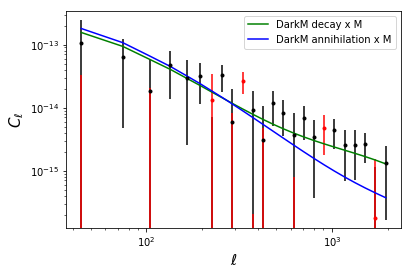

In [135]:
#For the gamma x galaxy with the highest sigma (4sigma) # 

all_pcl_4sigma = all_pcl['galaxy x gamma:4x4']
plt.errorbar(ells,all_pcl_4sigma, yerr = all_jackerrors['jkerr4x4'], fmt = 'k.')
plt.errorbar(ells, -all_pcl_4sigma, yerr = all_jackerrors['jkerr4x4'], fmt = 'r.')


plt.plot(ells, cl_MxM*a10[4,4], 'g-', label = 'DarkM decay x M')
plt.plot(ells, cl_DxM*a20[4,4], 'b-', label = 'DarkM annihilation x M')
plt.xlabel('$\ell$', fontsize =15)
plt.ylabel('$C_{\ell}$', fontsize = 15)
plt.legend()
plt.loglog()
fig.set_size_inches(13.5, 8.5)
plt.savefig('4_sigma_4x4_maps.jpg', format = 'jpg', dpi =200 )


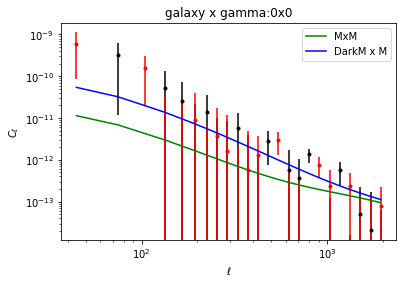

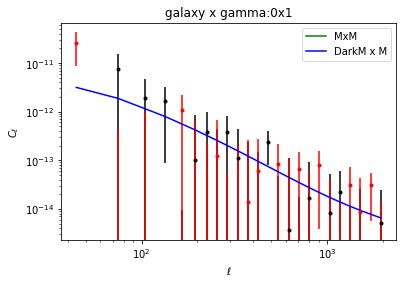

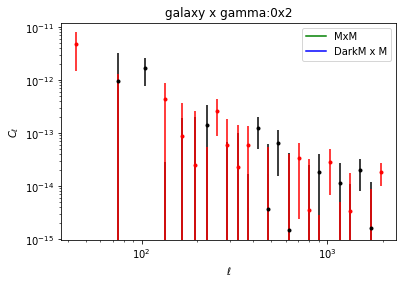

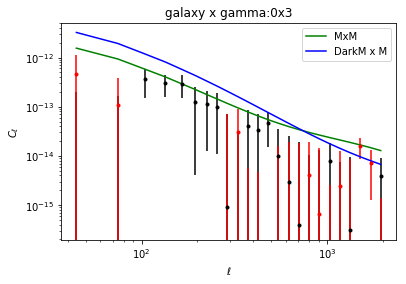

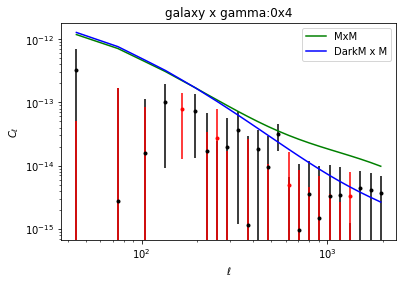

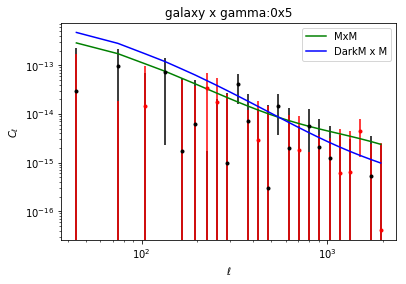

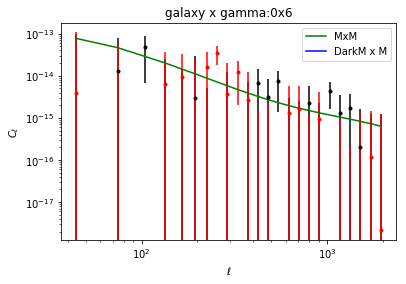

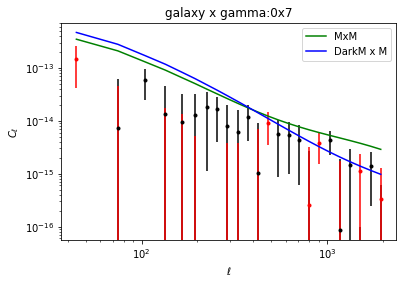

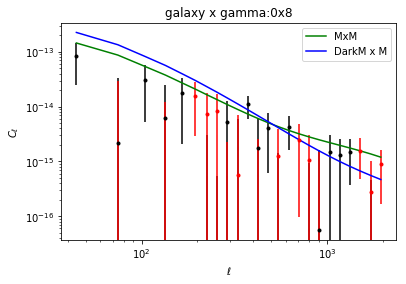

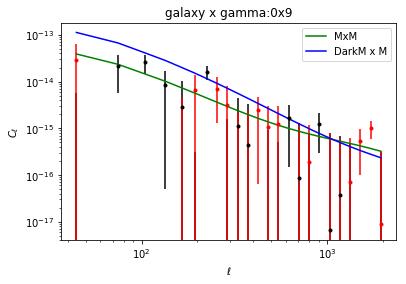

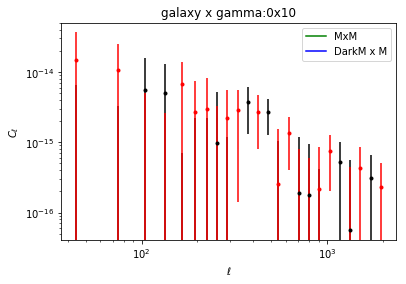

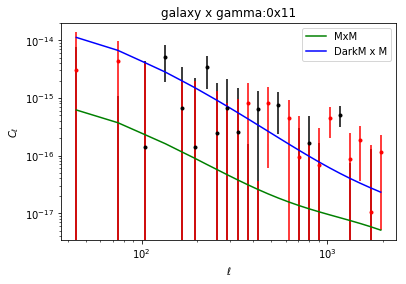

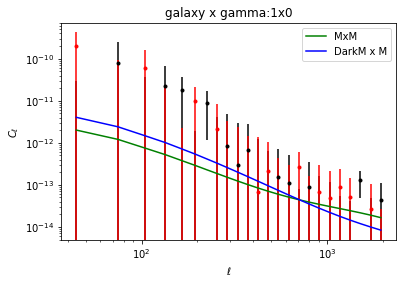

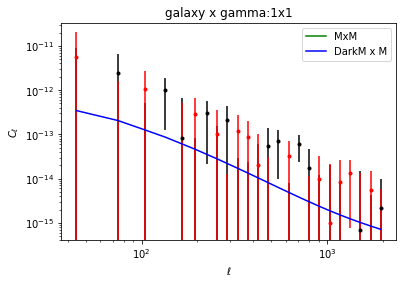

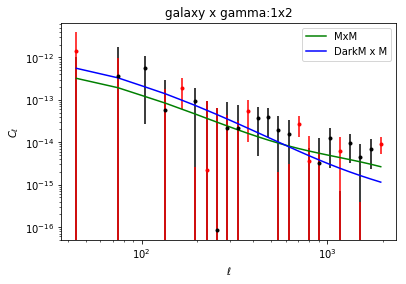

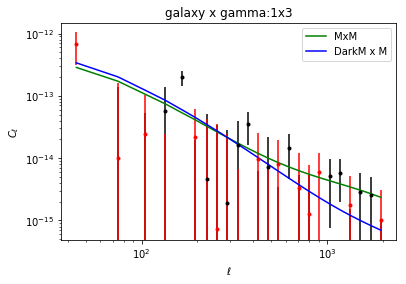

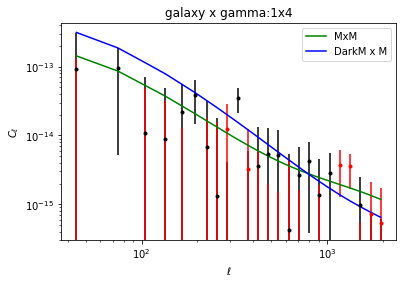

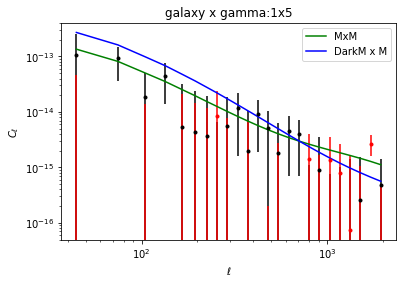

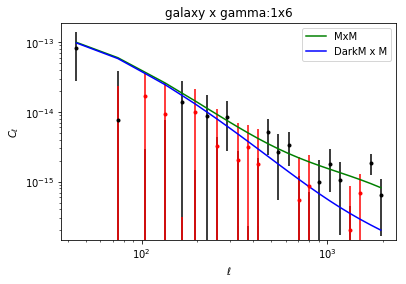

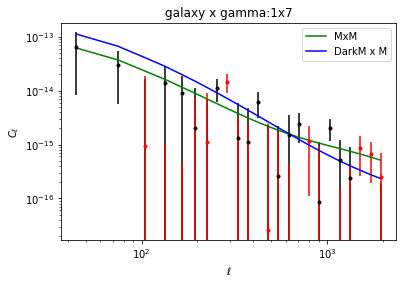

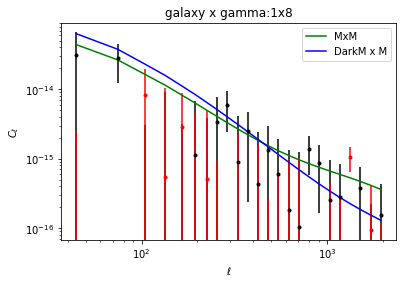

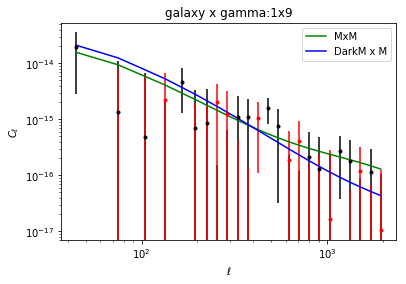

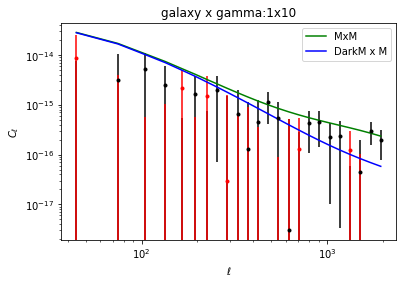

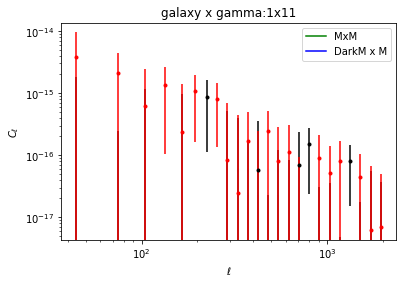

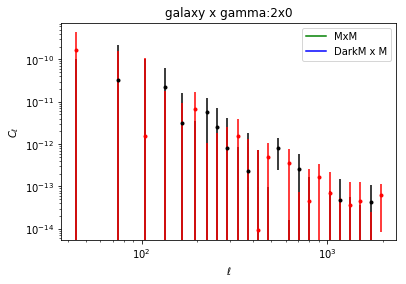

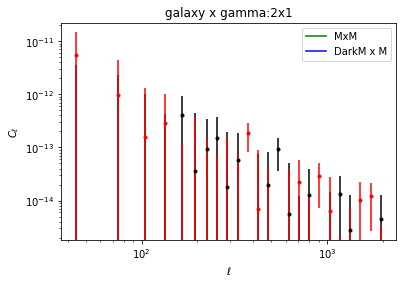

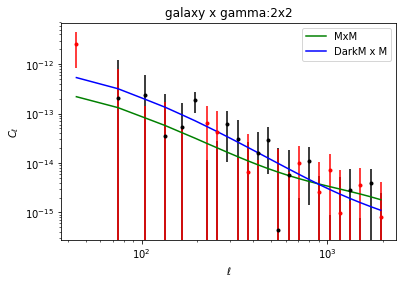

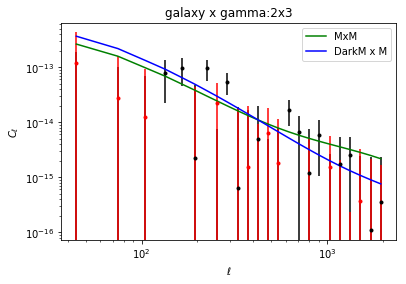

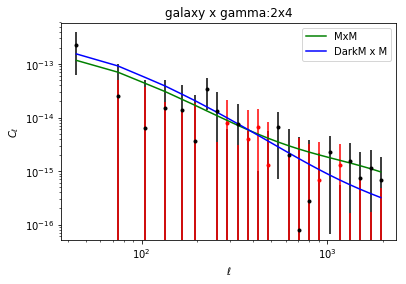

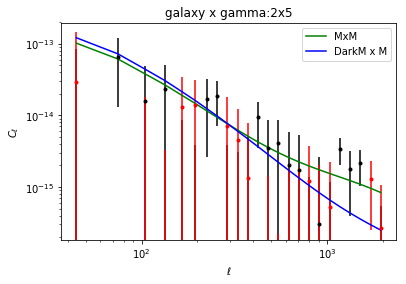

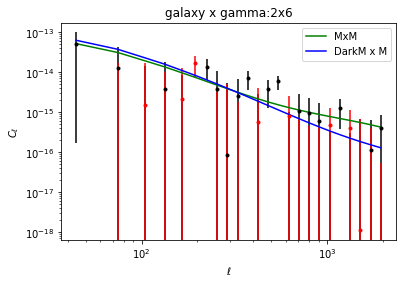

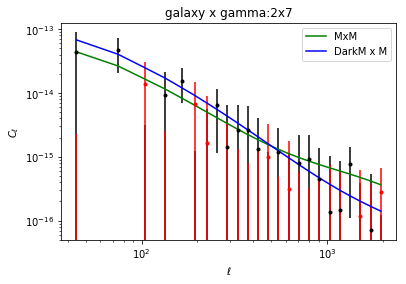

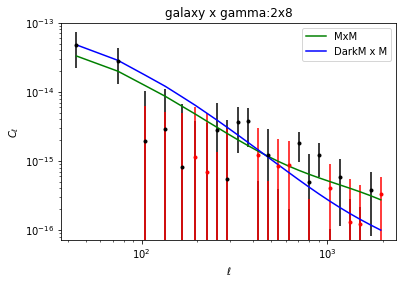

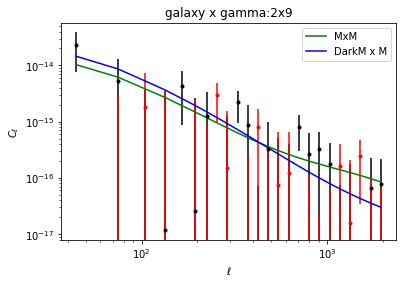

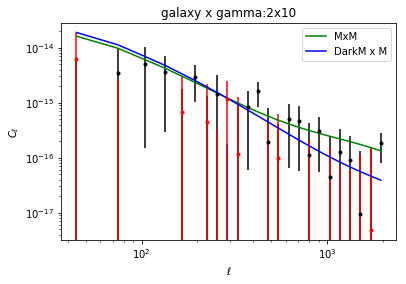

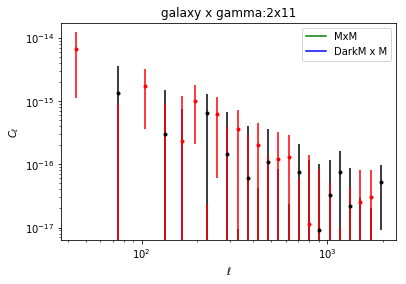

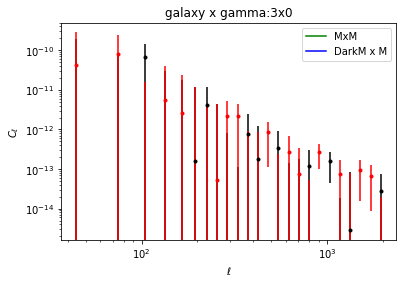

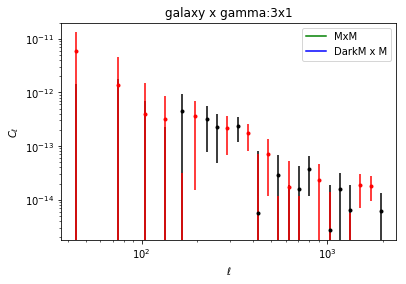

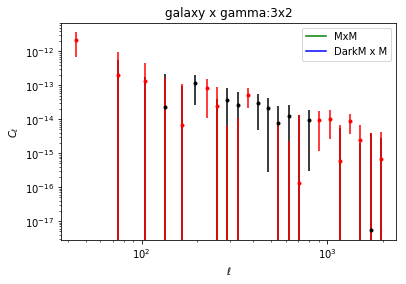

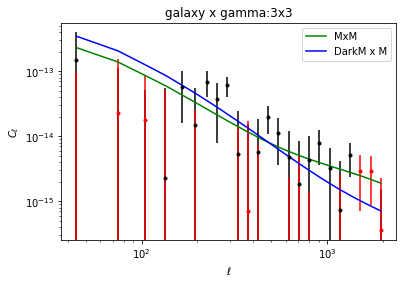

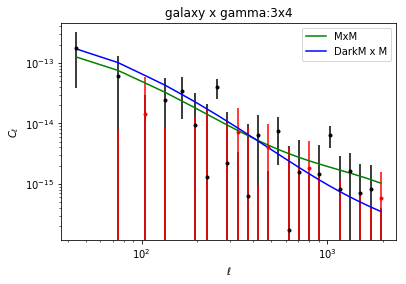

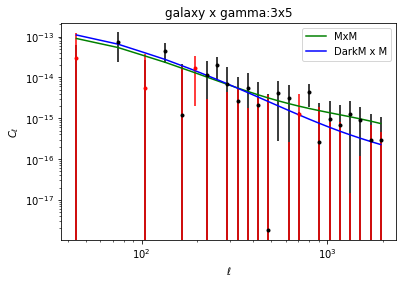

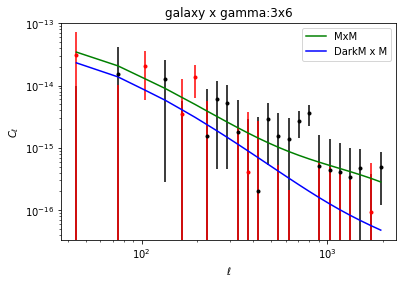

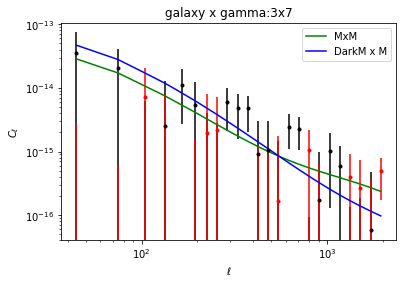

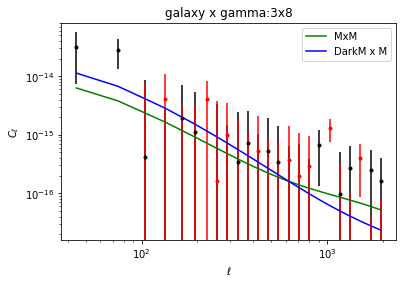

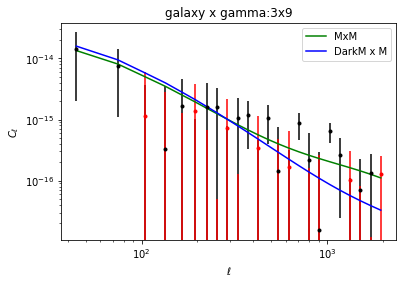

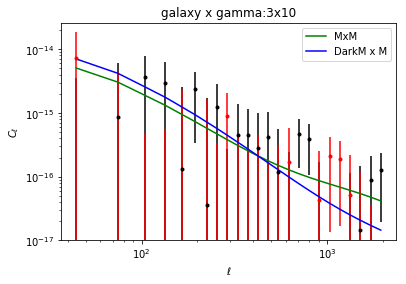

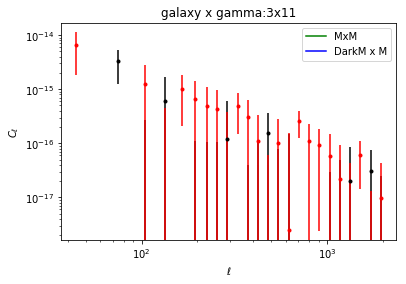

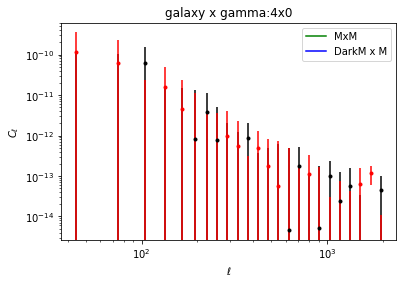

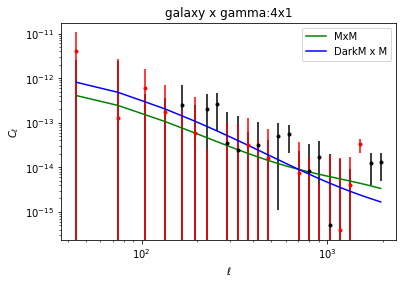

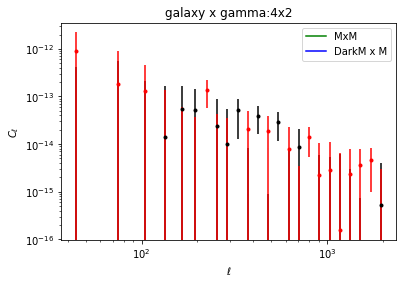

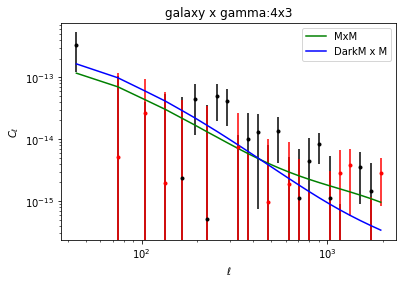

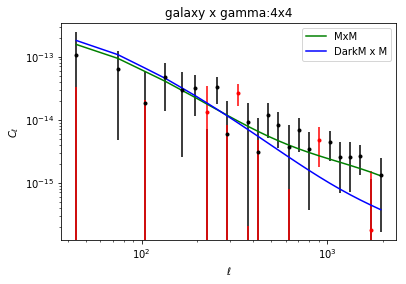

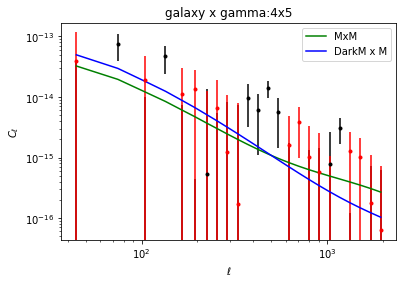

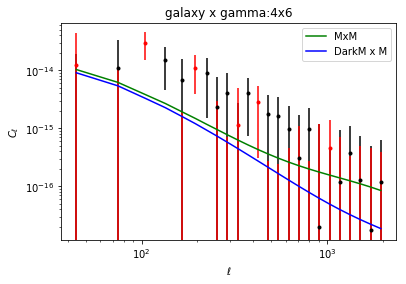

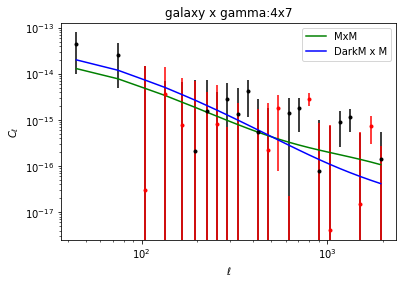

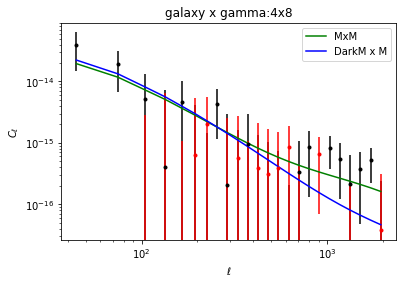

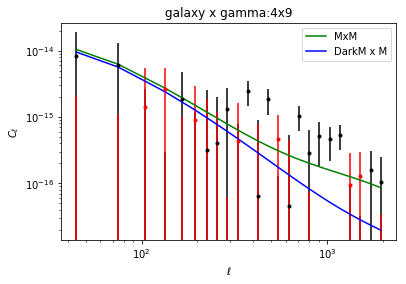

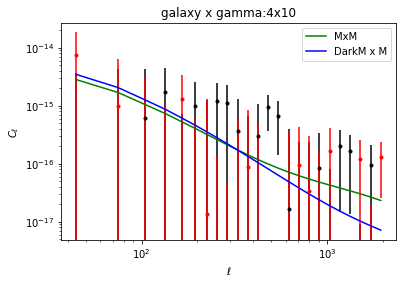

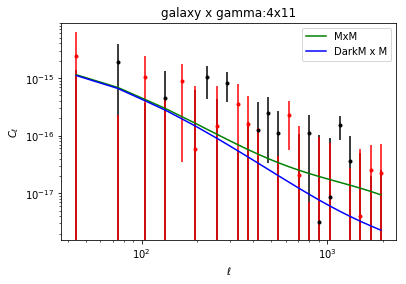

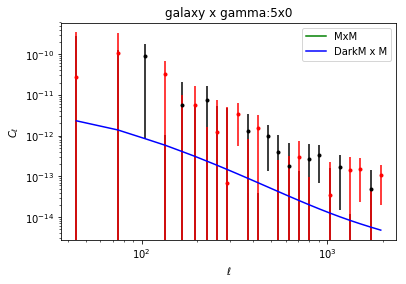

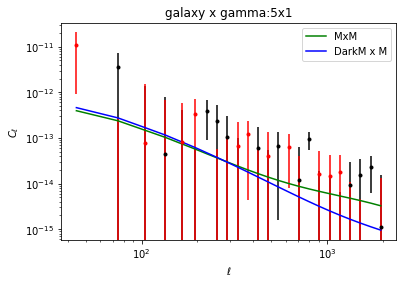

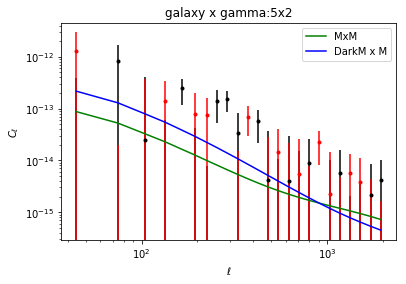

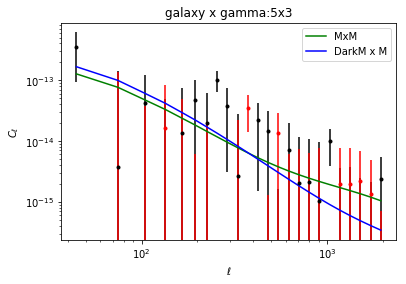

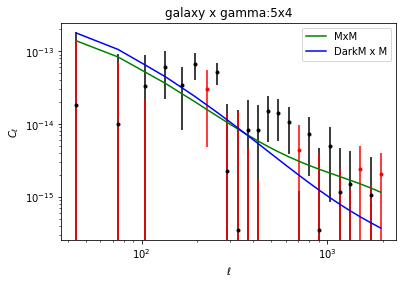

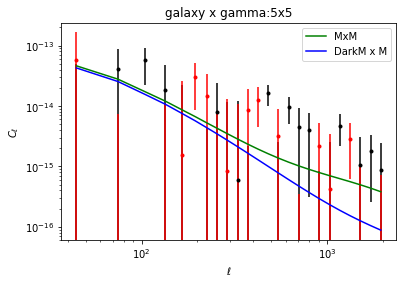

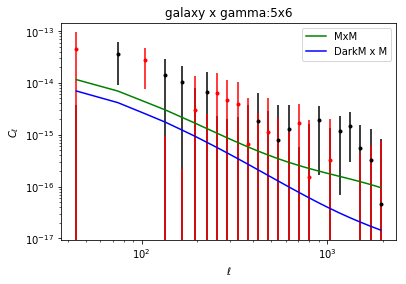

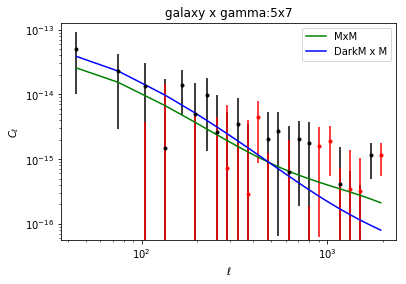

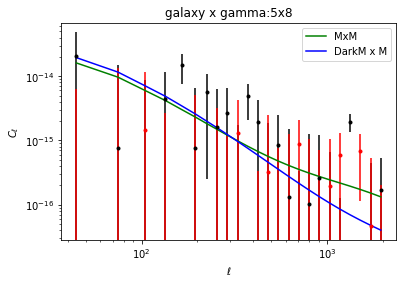

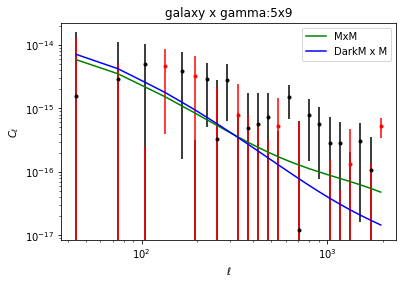

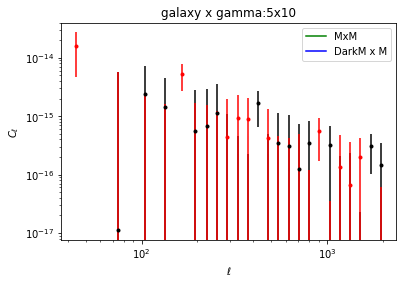

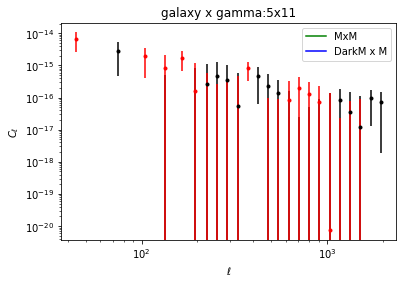

In [136]:
Total_plots = np.arange(1,73)
for i,pcl,jk,name in zip(Total_plots,all_pcl.values(),all_jackerrors.values(),plot_names):
    fig = plt.figure()
    plt.errorbar(ells,pcl, yerr = jk, fmt = 'k.')
    plt.errorbar(ells, -pcl, yerr = jk, fmt = 'r.')
    plt.plot(ells, cl_MxM*aay10[i-1], 'g-', label = 'MxM')
    plt.plot(ells, cl_DxM*aay20[i-1], 'b-', label = 'DarkM x M')
    plt.xlabel('$\ell$')
    plt.ylabel('$C_{\ell}$')
    plt.title(f'{name}')
    plt.legend()
    plt.loglog()

    
    


In [138]:

Edges = [5.24807460e+02, 1.00000000e+03, 1.73780083e+03, 3.01995172e+03,
 5.24807460e+03, 8.31763771e+03, 1.58489319e+04, 2.29086765e+04,
 3.98107171e+04, 7.58577575e+04, 1.20226443e+05, 3.31131121e+05,
 1.00000000e+06]

Macrobins = []

print(Bins)
for start, end in zip(Edges, Edges[1:]):
    Macrobins.append(np.array([start, end]))
    
print(Macrobins)
Bins = np.array(Macrobins, dtype= 'int')
Z = z['0'] 
E = np.geomspace(5.24807460e+02,1.00000000e+06,256).astype(int)
Mnz = []
print(Bins[0,0])
#print(len(E[1]))
M_of_z = []
#trial heaviside (trying to make this work with a single bin first)
for n in range(1,len(E)):
    M = (np.minimum(E[n+1]/(1+Z),Bins[0,1])-np.maximum(E[n]/(1+Z), Bins[0,1]))*np.heaviside(np.minimum(E[n+1]/(1+Z),Bins[0,1])-np.maximum(E[n]/(1+Z), Bins[0,0]),1)   
    #Stuck on this 
    M_of_z.append(M)
    
    
    
    
#omegachi = 
#critical_density = 
# (1+z)**3
#need 8pi as well

#K_of_z = (((omegachi*critical_density)**2)/(8*np.pi))*(1+z)**3

t_gal = ccl.NumberCountsTracer(cosmo, has_rsd = False, dndz=(z['0'],dndz['0']), bias=(z['0'], np.ones_like(z['0'])))
ugraded_GRB_tracer = ccl.Tracer()
upgraded_GRB_tracer.add_tracer(cosmo, kernel = K_of_z*M_of_z)

T = ccl.angular_cl(cosmo, t_gal, upgraded_GRB_tracer, ells, p_of_k_a= pk_DMxMf)
#will probably need to make T into an array of 6x12, but will be choosing only a single galaxy bin to work with first 

M_matrix = np.sum(T[n]*T[m]/jk_err**2) # will need to make this correct but this is general idea (sum probably is not along correct axis)
V_matrix = np.sum(T[n]*PCL_data/jk_err**2)
#F_of_m = 

[[    524    1000]
 [   1000    1737]
 [   1737    3019]
 [   3019    5248]
 [   5248    8317]
 [   8317   15848]
 [  15848   22908]
 [  22908   39810]
 [  39810   75857]
 [  75857  120226]
 [ 120226  331131]
 [ 331131 1000000]]
[array([ 524.80746, 1000.     ]), array([1000.     , 1737.80083]), array([1737.80083, 3019.95172]), array([3019.95172, 5248.0746 ]), array([5248.0746 , 8317.63771]), array([ 8317.63771, 15848.9319 ]), array([15848.9319, 22908.6765]), array([22908.6765, 39810.7171]), array([39810.7171, 75857.7575]), array([ 75857.7575, 120226.443 ]), array([120226.443, 331131.121]), array([ 331131.121, 1000000.   ])]
524


IndexError: index 256 is out of bounds for axis 0 with size 256